# **Desafio IHM Stefanini - 05 - XGBoost**

Será feito um modelo de regressão utilizando a biblioteca XGBoost para prever variável `% Silica Concentrate`. Serão feitos 4 modelos:
1. Modelo com todas as variáveis;
2. Modelo apenas com as variáveis selecionados na etapa de preparação;
3. Modelo com todas as variáveis, mas excluindo a variável `% Iron Concentrate`;
4. Modelo apenas com as variáveis selecionados na etapa de preparação e excluindo a variável `% Iron Concentrate`;

## **Carregando as bibliotecas**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from xgboost import XGBRegressor

## **Configurações do notebook**

In [2]:
%matplotlib inline
sns.set(style='white')
pd.set_option('display.max_columns', None) # Apenas se precisar
#pd.set_option('display.max_rows', None) # Apenas se precisar
#pd.options.display.float_format = '{:.2f}'.format # Suprimindo notação científica e exibindo duas casas decimais
RANDOM_SEED = 1

## **Carregando os dados**

In [3]:
df = pd.read_csv("dados_ihm_stefanini/MiningProcess_Flotation_Plant_Database.csv", decimal=",")

In [4]:
df.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


## **Funções**

In [5]:
# Métricas
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['R2'] = r2_score(y_true, y_pred)
    metrics_dict['MSE'] = mean_squared_error(y_true, y_pred)
    metrics_dict['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    return metrics_dict

In [6]:
# Normalização (MinMax) da variável objetivo
def normY(y):
    y_max = y.max()
    y_min = y.min()
    y_norm = (y - y_min) / (y_max - y_min)

    return y_norm, y_max, y_min

# Desfaz a normalização (MinMax) da variável objetivo
def inverse_normY(y_norm, y_max, y_min):
    y_inv = y_norm * (y_max - y_min) + y_min

    return y_inv

## **Removendo as colunas que não serão utilizadas**

Será removida apenas a coluna: `date`.

In [7]:
df.drop(columns=['date'], inplace=True)

## **Construção dos modelos**

### **Modelo XGBRegressor com todas as variáveis**

#### **Separação dos dados em teste e treino**

In [8]:
X = df.drop(columns=['% Silica Concentrate'])
y = df['% Silica Concentrate']

In [9]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [10]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [11]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [12]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [13]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)
    min_split_loss = trial.suggest_float('min_split_loss', 0, 10)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 8)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.0001, 1)

    # Instanciando o XGBRegressor
    xgbr = XGBRegressor(learning_rate=learning_rate, min_split_loss=min_split_loss, max_depth=max_depth, 
                        min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, random_state=RANDOM_SEED)

    # Métrica do modelo com validação cruzada
    score = cross_val_score(xgbr, X=X_train, y=y_train_norm, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')

    # Métrica
    mean_score = (-1) * score.mean()

    return mean_score

In [14]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-20 08:38:33,170] A new study created in memory with name: no-name-9264f071-d0da-4faa-8a4b-9593dd50ed37
[I 2024-10-20 08:38:36,965] Trial 0 finished with value: 0.01420659700416404 and parameters: {'learning_rate': 0.41708030250210376, 'min_split_loss': 7.203244934421581, 'max_depth': 1, 'min_child_weight': 3, 'colsample_bytree': 0.1468412152280313}. Best is trial 0 with value: 0.01420659700416404.
[I 2024-10-20 08:38:41,970] Trial 1 finished with value: 0.009537286365723385 and parameters: {'learning_rate': 0.09242936090932093, 'min_split_loss': 1.862602113776709, 'max_depth': 4, 'min_child_weight': 4, 'colsample_bytree': 0.5388628523299566}. Best is trial 1 with value: 0.009537286365723385.
[I 2024-10-20 08:38:45,661] Trial 2 finished with value: 0.013687585659237856 and parameters: {'learning_rate': 0.41925259495185446, 'min_split_loss': 6.852195003967595, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.02748485443860637}. Best is trial 1 with value: 0.0095372

In [15]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.0020433143041549504
Melhores parâmetros: {'learning_rate': 0.6851993995950605, 'min_split_loss': 0.005857015317579843, 'max_depth': 6, 'min_child_weight': 8, 'colsample_bytree': 0.9083736320410661}


#### **Treinando o modelo com os parâmetros ajustados:**

In [16]:
xgbr = XGBRegressor(learning_rate=melhores_parametros['learning_rate'], min_split_loss=melhores_parametros['min_split_loss'],
                    max_depth=melhores_parametros['max_depth'], min_child_weight=melhores_parametros['min_child_weight'], 
                    colsample_bytree=melhores_parametros['colsample_bytree'], random_state=RANDOM_SEED)

xgbr.fit(X_train, y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9083736320410661, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.6851993995950605, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=8, min_split_loss=0.005857015317579843,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

#### **Avaliando o modelo**

In [17]:
# Fazendo previsões - os valores resultantes são normalizados
y_pred_norm = xgbr.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

In [18]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.9622992249616783,
 'MSE': np.float64(0.04801953034155489),
 'RMSE': np.float64(0.21913359017173722)}

**Gráfico para a avaliação dos resultados:**

In [19]:
#Separando 100 amostras dos dados previstos e dos dados de teste
df_temp = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).reset_index(drop=True)

df_sample = df_temp.sample(n=100, random_state=RANDOM_SEED).reset_index(drop=True)

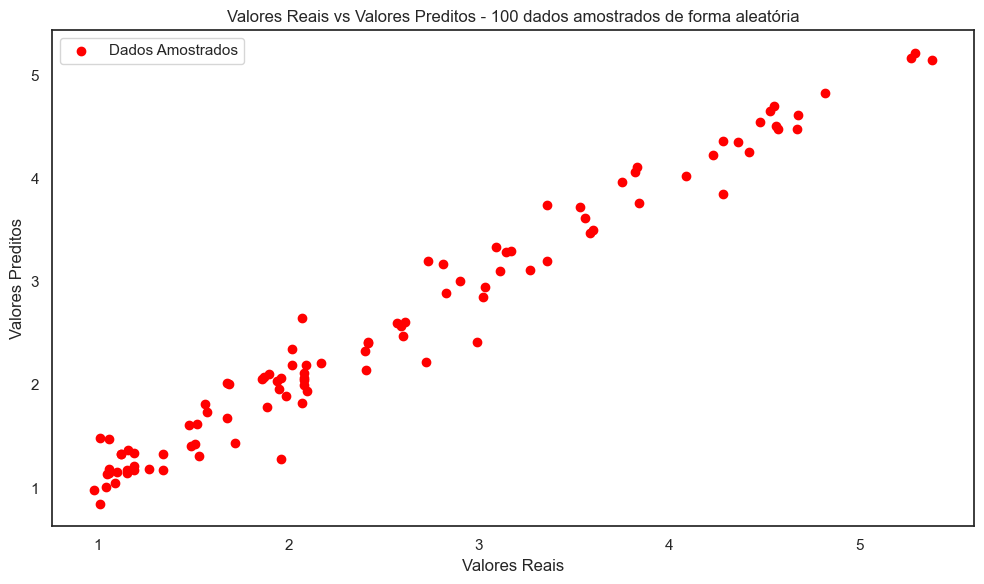

In [21]:
# Plotando os dados amostrados
plt.figure(figsize=(10, 6))
plt.scatter(df_sample.y_test, df_sample.y_pred, color='red', label='Dados Amostrados')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Valores Preditos - 100 dados amostrados de forma aleatória')
plt.legend()
plt.tight_layout()
#plt.savefig("dados_ihm_stefanini/resultados_xgbregressor.png")

### **Modelo XGBRegressor com as variáveis selecionadas**

#### **Separação dos dados em teste e treino**

In [59]:
X = df[["Amina Flow", "Ore Pulp pH", "Flotation Column 01 Air Flow",
        "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow", "Flotation Column 04 Level", 
        "Flotation Column 05 Level", "Flotation Column 06 Level", "Flotation Column 07 Level",
        "% Iron Concentrate"]].copy()
y = df['% Silica Concentrate']

In [60]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [61]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [62]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [63]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [64]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)
    min_split_loss = trial.suggest_float('min_split_loss', 0, 10)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 8)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.0001, 1)

    # Instanciando o XGBRegressor
    xgbr = XGBRegressor(learning_rate=learning_rate, min_split_loss=min_split_loss, max_depth=max_depth, 
                        min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, random_state=RANDOM_SEED)

    # Métrica do modelo com validação cruzada
    score = cross_val_score(xgbr, X=X_train, y=y_train_norm, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')

    # Métrica
    mean_score = (-1) * score.mean()

    return mean_score

In [65]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-13 11:04:27,427] A new study created in memory with name: no-name-b08911e1-08be-49d0-ac7b-990df7cab0d9
[I 2024-10-13 11:04:29,882] Trial 0 finished with value: 0.016129756767253714 and parameters: {'learning_rate': 0.41708030250210376, 'min_split_loss': 7.203244934421581, 'max_depth': 1, 'min_child_weight': 3, 'colsample_bytree': 0.1468412152280313}. Best is trial 0 with value: 0.016129756767253714.
[I 2024-10-13 11:04:33,930] Trial 1 finished with value: 0.012495293112330233 and parameters: {'learning_rate': 0.09242936090932093, 'min_split_loss': 1.862602113776709, 'max_depth': 4, 'min_child_weight': 4, 'colsample_bytree': 0.5388628523299566}. Best is trial 1 with value: 0.012495293112330233.
[I 2024-10-13 11:04:36,660] Trial 2 finished with value: 0.01467383745637853 and parameters: {'learning_rate': 0.41925259495185446, 'min_split_loss': 6.852195003967595, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.02748485443860637}. Best is trial 1 with value: 0.012495

In [66]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.0033338899579271426
Melhores parâmetros: {'learning_rate': 0.7261188768958959, 'min_split_loss': 0.006116167548455023, 'max_depth': 8, 'min_child_weight': 6, 'colsample_bytree': 0.9405044184686224}


#### **Treinando o modelo com os parâmetros ajustados:**

In [67]:
xgbr = XGBRegressor(learning_rate=melhores_parametros['learning_rate'], min_split_loss=melhores_parametros['min_split_loss'],
                    max_depth=melhores_parametros['max_depth'], min_child_weight=melhores_parametros['min_child_weight'], 
                    colsample_bytree=melhores_parametros['colsample_bytree'], random_state=RANDOM_SEED)

xgbr.fit(X_train, y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9405044184686224, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.7261188768958959, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=6, min_split_loss=0.006116167548455023,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

#### **Avaliando o modelo**

In [68]:
# Fazendo previsões - os valores resultantes são normalizados
y_pred_norm = xgbr.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

In [69]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.9421268050345819,
 'MSE': np.float64(0.07371317005498698),
 'RMSE': np.float64(0.27150169438695404)}

### **Modelo XGBRegressor com todas as variáveis, mas excluindo a variável % Iron Concentrate**

#### **Separação dos dados em teste e treino**

In [70]:
X = df.drop(columns=['% Iron Concentrate', '% Silica Concentrate'])
y = df['% Silica Concentrate']

In [71]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [72]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [73]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [74]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [75]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)
    min_split_loss = trial.suggest_float('min_split_loss', 0, 10)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 8)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.0001, 1)

    # Instanciando o XGBRegressor
    xgbr = XGBRegressor(learning_rate=learning_rate, min_split_loss=min_split_loss, max_depth=max_depth, 
                        min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, random_state=RANDOM_SEED)

    # Métrica do modelo com validação cruzada
    score = cross_val_score(xgbr, X=X_train, y=y_train_norm, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')

    # Métrica
    mean_score = (-1) * score.mean()

    return mean_score

In [76]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-13 11:07:03,393] A new study created in memory with name: no-name-fb6ee923-e4a2-49de-b3c1-6503067d8787
[I 2024-10-13 11:07:07,252] Trial 0 finished with value: 0.03994810874564236 and parameters: {'learning_rate': 0.41708030250210376, 'min_split_loss': 7.203244934421581, 'max_depth': 1, 'min_child_weight': 3, 'colsample_bytree': 0.1468412152280313}. Best is trial 0 with value: 0.03994810874564236.
[I 2024-10-13 11:07:13,221] Trial 1 finished with value: 0.030368302526458203 and parameters: {'learning_rate': 0.09242936090932093, 'min_split_loss': 1.862602113776709, 'max_depth': 4, 'min_child_weight': 4, 'colsample_bytree': 0.5388628523299566}. Best is trial 1 with value: 0.030368302526458203.
[I 2024-10-13 11:07:17,731] Trial 2 finished with value: 0.03604664561836091 and parameters: {'learning_rate': 0.41925259495185446, 'min_split_loss': 6.852195003967595, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.02748485443860637}. Best is trial 1 with value: 0.03036830

In [77]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.012110134791974824
Melhores parâmetros: {'learning_rate': 0.7748378047767136, 'min_split_loss': 0.10850056291820573, 'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.4311617112309767}


#### **Treinando o modelo com os parâmetros ajustados:**

In [78]:
xgbr = XGBRegressor(learning_rate=melhores_parametros['learning_rate'], min_split_loss=melhores_parametros['min_split_loss'],
                    max_depth=melhores_parametros['max_depth'], min_child_weight=melhores_parametros['min_child_weight'], 
                    colsample_bytree=melhores_parametros['colsample_bytree'], random_state=RANDOM_SEED)

xgbr.fit(X_train, y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4311617112309767, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.7748378047767136, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, min_split_loss=0.10850056291820573,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

#### **Avaliando o modelo**

In [79]:
# Fazendo previsões - os valores resultantes são normalizados
y_pred_norm = xgbr.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

In [80]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.7863763380997755,
 'MSE': np.float64(0.2720927594688659),
 'RMSE': np.float64(0.5216251139169451)}

### **Modelo XGBRegressor com as variáveis selecionadas, mas excluindo a variável % Iron Concentrate**

#### **Separação dos dados em teste e treino**

In [81]:
X = df[["Amina Flow", "Ore Pulp pH", "Flotation Column 01 Air Flow",
        "Flotation Column 02 Air Flow", "Flotation Column 03 Air Flow", "Flotation Column 04 Level", 
        "Flotation Column 05 Level", "Flotation Column 06 Level", "Flotation Column 07 Level"]].copy()
y = df['% Silica Concentrate']

In [82]:
# Separando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

#### **Normalização das colunas**

**Dados de treino:**

In [83]:
# X_train
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

In [84]:
# y_train
y_train_norm, y_train_max, y_train_min = normY(y_train)

**Dados de teste:**

In [85]:
# X_test
X_test = scaler.transform(X_test)

#### **Ajuste dos hiperparâmetros com Optuna**

In [86]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1)
    min_split_loss = trial.suggest_float('min_split_loss', 0, 10)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 8)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.0001, 1)

    # Instanciando o XGBRegressor
    xgbr = XGBRegressor(learning_rate=learning_rate, min_split_loss=min_split_loss, max_depth=max_depth, 
                        min_child_weight=min_child_weight, colsample_bytree=colsample_bytree, random_state=RANDOM_SEED)

    # Métrica do modelo com validação cruzada
    score = cross_val_score(xgbr, X=X_train, y=y_train_norm, cv=KFold(n_splits=5), scoring='neg_mean_squared_error')

    # Métrica
    mean_score = (-1) * score.mean()

    return mean_score

In [87]:
sampler = TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)
#optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=50)

[I 2024-10-13 11:11:23,569] A new study created in memory with name: no-name-a1183142-332e-4f96-94e5-124debb4b59e
[I 2024-10-13 11:11:25,823] Trial 0 finished with value: 0.04312549970208122 and parameters: {'learning_rate': 0.41708030250210376, 'min_split_loss': 7.203244934421581, 'max_depth': 1, 'min_child_weight': 3, 'colsample_bytree': 0.1468412152280313}. Best is trial 0 with value: 0.04312549970208122.
[I 2024-10-13 11:11:29,376] Trial 1 finished with value: 0.03966191013854796 and parameters: {'learning_rate': 0.09242936090932093, 'min_split_loss': 1.862602113776709, 'max_depth': 4, 'min_child_weight': 4, 'colsample_bytree': 0.5388628523299566}. Best is trial 1 with value: 0.03966191013854796.
[I 2024-10-13 11:11:31,612] Trial 2 finished with value: 0.042825181109265524 and parameters: {'learning_rate': 0.41925259495185446, 'min_split_loss': 6.852195003967595, 'max_depth': 3, 'min_child_weight': 8, 'colsample_bytree': 0.02748485443860637}. Best is trial 1 with value: 0.039661910

In [88]:
melhores_parametros = study.best_params

print(f"Melhor MSE: {study.best_trial.value}")
print(f"Melhores parâmetros: {study.best_params}")

Melhor MSE: 0.030878155949957686
Melhores parâmetros: {'learning_rate': 0.5162466584141424, 'min_split_loss': 0.00328097600095803, 'max_depth': 7, 'min_child_weight': 7, 'colsample_bytree': 0.9320472423532754}


#### **Treinando o modelo com os parâmetros ajustados:**

In [89]:
xgbr = XGBRegressor(learning_rate=melhores_parametros['learning_rate'], min_split_loss=melhores_parametros['min_split_loss'],
                    max_depth=melhores_parametros['max_depth'], min_child_weight=melhores_parametros['min_child_weight'], 
                    colsample_bytree=melhores_parametros['colsample_bytree'], random_state=RANDOM_SEED)

xgbr.fit(X_train, y_train_norm)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9320472423532754, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5162466584141424, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=7, min_split_loss=0.00328097600095803,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)

#### **Avaliando o modelo**

In [90]:
# Fazendo previsões - os valores resultantes são normalizados
y_pred_norm = xgbr.predict(X_test)

# Valores resultantes das previsões em seu formato real
y_pred = inverse_normY(y_pred_norm, y_train_max, y_train_min)

In [91]:
# Avaliando o modelo XGB
eval_metrics(y_test, y_pred)

{'R2': 0.41699648564650027,
 'MSE': np.float64(0.7425723985322413),
 'RMSE': np.float64(0.8617264058459863)}